Dataloader:

In [13]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch

# --- DEFINE HYPERPARAMETERS ---
T_steps = 1000  # Total number of diffusion steps
IMG_SIZE = 32 # CIFAR-10 image size
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define the transform. We use the same for train and val.
# We normalize to [-1, 1], which is standard for diffusion models
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scale to [-1, 1]
])

# --- Train Dataloader ---
train_dataset = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True, # Will use local data if already downloaded
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# --- Validation/Test Dataloader ---
# We use the CIFAR-10 "test" set as our validation set.
val_dataset = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)
# No shuffle for val/test loader, use more workers if available
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Data loaded: {len(train_dataset)} train images, {len(val_dataset)} validation images.")
print("Created 'train_loader' and 'val_loader'.")

Data loaded: 50000 train images, 10000 validation images.
Created 'train_loader' and 'val_loader'.


Forward diffusion process:

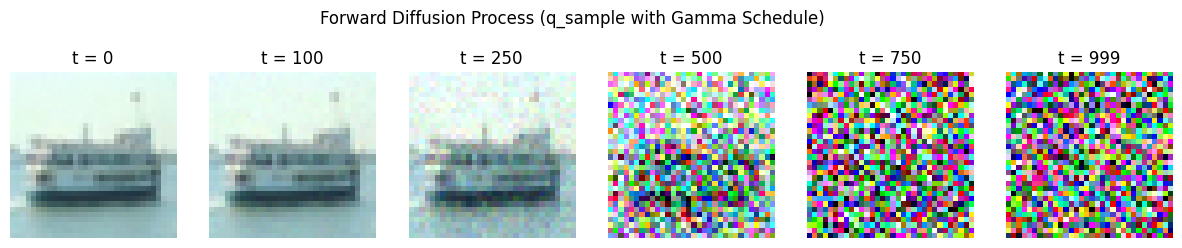

In [14]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F  # We need this for F.pad
import numpy as np
import matplotlib.pyplot as plt

# --- DEFINE THE NOISE SCHEDULE ---
# We now define a schedule for gamma, which is -log(SNR(t))
# A linear schedule for gamma is a common starting point.
def gamma_schedule(timesteps, min_val=-10.0, max_val=10.0):
    """
    Returns a tensor of gamma values (log-SNR schedule)
    from min_val to max_val over T timesteps.
    """
    return torch.linspace(min_val, max_val, timesteps, device=DEVICE)

# --- 3. PRE-CALCULATE DIFFUSION CONSTANTS ---
# All constants are now derived from gamma.

# Get the full gamma schedule
gamma = gamma_schedule(timesteps=T_steps)

# Calculate $\bar{\alpha}_t$ (alphas_cumprod) from gamma
# Eq 4: $\alpha_t^2 = sigmoid(-\gamma(t))$
# Note: The paper's $\alpha_t^2$ is the DDPM $\bar{\alpha}_t$ (alphas_cumprod)
alphas_cumprod = torch.sigmoid(-gamma)

# Calculate $\sigma_t^2$ (1 - $\bar{\alpha}_t$) from gamma
# Eq 3: $\sigma_t^2 = sigmoid(\gamma(t))$
# (Sanity check: sigmoid(-g) + sigmoid(g) == 1)
sigmas_cumprod = torch.sigmoid(gamma) # This is $\sigma_t^2$ in VDM notation

# --- Key constants for the "jump" formula (q_sample) ---
# These are the values needed for x_t = \alpha_t * x_0 + \sigma_t * noise
# (Using VDM paper's notation, where $\alpha_t = \sqrt{\bar{\alpha}_t}$ in DDPM)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(sigmas_cumprod) # This is $\sigma_t$

# --- Constants for the reverse process (denoising) ---
# We can derive the posterior variance (Eq 33) directly from gamma.
# This replaces the old beta-based calculation.

# Get $\gamma_{t-1}$
gamma_prev = F.pad(gamma[:-1], (1, 0), value=gamma[0])
# Get $\sigma_{t-1}^2$
sigmas_cumprod_prev = torch.sigmoid(gamma_prev) # $\sigma_s^2$ in Eq 33

# Eq 33: $\sigma_Q^2(s,t) = \sigma_s^2 \cdot (-expm1(\gamma_s - \gamma_t))$
# (where s=t-1 and t=t)
# torch.expm1(x) calculates exp(x) - 1 in a numerically stable way.
posterior_variance = sigmas_cumprod_prev * (-torch.expm1(gamma_prev - gamma))

# We clamp this to avoid numerical issues at t=0
posterior_variance[0] = 1e-20


# --- THE FORWARD (NOISING) FUNCTION ---
# This function implements the efficient jump: x_0 -> x_t
# THIS FUNCTION REMAINS IDENTICAL, as it only depends on the
# sqrt_..._cumprod values, which we have correctly derived.

def q_sample(x_start, t, noise=None):
    """
    Noises a batch of images x_start to a specific timestep t.
    x_start: (B, C, H, W) - the original clean images
    t: (B,) - a tensor of timesteps for each image in the batch
    """
    if noise is None:
        noise = torch.randn_like(x_start, device=DEVICE) # $\epsilon$ ~ N(0, I)

    # 1. Get the $\sqrt{\bar{\alpha}_t}$ value for each t in the batch
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.gather(0, t).reshape(x_start.shape[0], 1, 1, 1)

    # 2. Get the $\sqrt{1 - \bar{\alpha}_t}$ value
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(0, t).reshape(x_start.shape[0], 1, 1, 1)

    # 3. Apply the formula
    # x_t = \alpha_t * x_0 + \sigma_t * noise
    noisy_image = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    return noisy_image, noise # Return noise so we can use it as the "label"

# --- HELPER FUNCTION FOR VISUALIZATION ---
def unnormalize_img(img_tensor):
    """Converts a tensor from [-1, 1] to [0, 1] for plotting."""
    img_tensor = (img_tensor + 1) * 0.5
    img_tensor = torch.clamp(img_tensor, 0, 1) # Clamp values
    img_tensor = img_tensor.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    return img_tensor.cpu().numpy()

# --- DATA LOADING & VISUALIZATION TEST ---
if __name__ == "__main__":
    # Load CIFAR-10
    transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scale to [-1, 1]
    ])

    # dataset = torchvision.datasets.CIFAR10(
    #     root="data",
    #     train=True,
    #     download=False,
    #     transform=transform
    # )
    # dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Get one batch of images
    x_start_batch, _ = next(iter(train_loader))
    x_start_batch = x_start_batch.to(DEVICE)

    # --- Test the forward pass ---

    # Get a single image to test
    x_start_single = x_start_batch[0].unsqueeze(0) # (1, C, H, W)

    # Define a few timesteps to visualize
    timesteps_to_show = [0, 100, 250, 500, 750, 999]
    num_steps = len(timesteps_to_show)

    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    fig.suptitle("Forward Diffusion Process (q_sample with Gamma Schedule)")

    for i, t_val in enumerate(timesteps_to_show):
        # Create a tensor for the timestep
        t = torch.tensor([t_val], device=DEVICE).long()

        # Apply the noising process
        noisy_img, noise_added = q_sample(x_start_single, t)

        # Plot
        axes[i].imshow(unnormalize_img(noisy_img[0]))
        axes[i].set_title(f"t = {t_val}")
        axes[i].axis('off')

    plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Sinusoidal Time Embedding ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Input:
            time: (B,) tensor of time steps
        Output:
            (B, dim) tensor of embeddings
        """
        device = time.device
        half_dim = self.dim // 2

        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

# --- Core Building Block ---
class SimpleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()

        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

    def forward(self, x, t_emb):
        h = self.conv(x)
        h = self.norm(h)

        time_bias = self.time_mlp(t_emb)
        h = h + time_bias.unsqueeze(-1).unsqueeze(-1)

        return self.act(h)

# --- The U-Net Architecture ---
# This version is closer to the VDM paper's CIFAR-10 model.
# All operations happen at the same 32x32 resolution.

class SimpleUNet(nn.Module):
    def __init__(self, img_channels=3, base_dim=64, time_emb_dim=256):
        """
        A U-Net without downsampling/upsampling.
        Resolution stays constant (e.g., 32x32).
        """
        super().__init__()

        # --- Time Embedding ---
        self.time_mlp = SinusoidalPositionEmbeddings(time_emb_dim)

        # --- Input ---
        # Input: (B, 3, 32, 32)
        self.conv_in = SimpleBlock(img_channels, base_dim, time_emb_dim) # (B, 64, 32, 32)

        # --- Encoder Path (No Pooling) ---
        self.down1 = SimpleBlock(base_dim, base_dim*2, time_emb_dim)     # 64 -> 128
        self.down2 = SimpleBlock(base_dim*2, base_dim*4, time_emb_dim)   # 128 -> 256

        # --- Bottleneck ---
        self.mid1 = SimpleBlock(base_dim*4, base_dim*8, time_emb_dim)     # 256 -> 512
        self.mid2 = SimpleBlock(base_dim*8, base_dim*4, time_emb_dim)     # 512 -> 256

        # --- Decoder Path (No Upsampling) ---
        # Skip connection 1
        # Input: mid2 (256) + down2 (256) = 512
        self.up1_block = SimpleBlock(base_dim*4 + base_dim*4, base_dim*2, time_emb_dim) # 512 -> 128

        # Skip connection 2
        # Input: up1 (128) + down1 (128) = 256
        self.up2_block = SimpleBlock(base_dim*2 + base_dim*2, base_dim, time_emb_dim) # 256 -> 64

        # --- Output ---
        # Skip connection 3
        # Input: up2 (64) + conv_in (64) = 128
        self.conv_out_block = SimpleBlock(base_dim + base_dim, base_dim, time_emb_dim) # 128 -> 64
        self.conv_out = nn.Conv2d(base_dim, img_channels, kernel_size=1) # 64 -> 3

    def forward(self, x_t, time):
        """
        Input:
            x_t: (B, C, H, W) noisy image at step t
            time: (B,) time steps
        Output:
            (B, C, H, W) predicted noise
        """

        # 1. Get time embedding
        t_emb = self.time_mlp(time)

        # 2. Encoder
        h_in = self.conv_in(x_t, t_emb)  # (B, 64, 32, 32)
        h_d1 = self.down1(h_in, t_emb)   # (B, 128, 32, 32)
        h_d2 = self.down2(h_d1, t_emb)   # (B, 256, 32, 32)

        # 3. Bottleneck
        h_mid = self.mid1(h_d2, t_emb)   # (B, 512, 32, 32)
        h_mid = self.mid2(h_mid, t_emb)  # (B, 256, 32, 32)

        # 4. Decoder
        # Skip connection 1
        up1_in = torch.cat([h_mid, h_d2], dim=1) # (B, 256 + 256 = 512, 32, 32)
        h_up1 = self.up1_block(up1_in, t_emb)    # (B, 128, 32, 32)

        # Skip connection 2
        up2_in = torch.cat([h_up1, h_d1], dim=1) # (B, 128 + 128 = 256, 32, 32)
        h_up2 = self.up2_block(up2_in, t_emb)    # (B, 64, 32, 32)

        # Skip connection 3
        out_in = torch.cat([h_up2, h_in], dim=1) # (B, 64 + 64 = 128, 32, 32)
        h_out = self.conv_out_block(out_in, t_emb) # (B, 64, 32, 32)

        # 5. Output
        return self.conv_out(h_out) # (B, 3, 32, 32)

# --- 4. TEST THE MODEL ---
if __name__ == "__main__":
    # Define some dummy values
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    T_steps = 1000 # Total timesteps

    # 1. Create dummy noisy image batch
    dummy_x = torch.randn(8, 3, 32, 32, device=DEVICE)

    # 2. Create dummy time batch
    dummy_t = torch.randint(0, T_steps, (8,), device=DEVICE).long()

    # 3. Initialize model and move to device
    # *** USE THE NEW MODEL NAME ***
    model = SimpleUNet().to(DEVICE)
    print(model)

    # 4. Run forward pass
    predicted_noise = model(dummy_x, dummy_t)

    # 5. Check output shape
    print("--- U-Net Test ---")
    print(f"Input image shape: {dummy_x.shape}")
    print(f"Input time shape:  {dummy_t.shape}")
    print(f"Output noise shape: {predicted_noise.shape}")

    assert dummy_x.shape == predicted_noise.shape
    print("\nSuccess! Output shape matches input shape.")

SimpleUNet(
  (time_mlp): SinusoidalPositionEmbeddings()
  (conv_in): SimpleBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
    (act): SiLU()
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (down1): SimpleBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
    (act): SiLU()
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (down2): SimpleBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    (act): SiLU()
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (mid1): SimpleBlock(
    (conv): Conv2d(256, 512, kernel_

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# (This cell assumes T, IMG_SIZE are defined in your vdm forward pass cell)
# (This cell assumes UNet is defined in your vdm_unet cell)

# --- 1. Hyperparameters ---
LEARNING_RATE = 1e-4  # A good starting learning rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. Initialize Model ---
# Move the model to the correct device (GPU or CPU)
model = SimpleUNet().to(DEVICE)

# --- 3. Define Loss Function ---
# We are predicting noise, so we use MSE Loss (L2 Loss).
# This measures the distance between the true noise (epsilon)
# and the noise predicted by the U-Net (model_output).
loss_fn = nn.MSELoss()

# --- 4. Define Optimizer ---
# Adam is a robust optimizer that works well for this task.
# We pass it the model's parameters (which it will update)
# and the learning rate.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 5. Confirmation & Test ---
print("--- Setup Complete ---")
print(f"Using device: {DEVICE}")
print(f"Model: {model.__class__.__name__}")
print(f"Loss Fn: {loss_fn.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")

# Quick test to ensure everything is connected:
try:
    dummy_x = torch.randn(2, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
    dummy_t = torch.randint(0, T_steps, (2,), device=DEVICE).long()

    # 1. Forward pass
    pred_noise = model(dummy_x, dummy_t)

    # 2. Calculate loss
    true_noise = torch.randn_like(pred_noise)
    loss = loss_fn(pred_noise, true_noise)

    # 3. Backward pass and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("\nTest step successful! (Forward, backward, and optimizer step ran.)")

except NameError as e:
    print(f"\n---")
    print(f"Test step failed: {e}")
    print("This is likely because a variable from a previous cell (like 'SimpleUNet' or 'T') is not defined.")
    print("Please make sure you have run the previous notebook cells.")
except Exception as e:
    print(f"\nTest step failed with an unexpected error: {e}")


--- Setup Complete ---
Using device: cuda
Model: SimpleUNet
Loss Fn: MSELoss
Optimizer: Adam

Test step successful! (Forward, backward, and optimizer step ran.)


--- Starting Training ---

--- Epoch 1/20 ---

--- Running Validation at Step 500 ---
Step 500      Training Loss: 0.1660  |  Validation Loss: 0.1591
Epoch 1 Complete. Time taken: 44.12s

--- Epoch 2/20 ---

--- Running Validation at Step 1000 ---
Step 1000     Training Loss: 0.1540  |  Validation Loss: 0.1525

--- Running Validation at Step 1500 ---
Step 1500     Training Loss: 0.1529  |  Validation Loss: 0.1527
Epoch 2 Complete. Time taken: 47.33s

--- Epoch 3/20 ---

--- Running Validation at Step 2000 ---
Step 2000     Training Loss: 0.1508  |  Validation Loss: 0.1471
Epoch 3 Complete. Time taken: 44.14s

--- Epoch 4/20 ---

--- Running Validation at Step 2500 ---
Step 2500     Training Loss: 0.1489  |  Validation Loss: 0.1485

--- Running Validation at Step 3000 ---
Step 3000     Training Loss: 0.1494  |  Validation Loss: 0.1466
Epoch 4 Complete. Time taken: 47.32s

--- Epoch 5/20 ---

--- Running Validation at Step 3500 ---
Step 3500     Training Loss: 0.1498  |  Validation Loss:

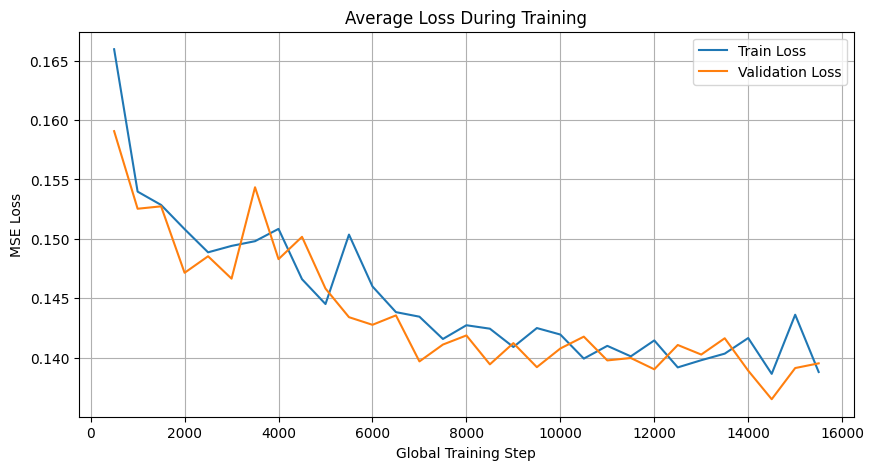

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time # Import time for simple progress logging

# (This cell assumes all variables from previous cells are defined and in scope)
# Requires:
#   - train_loader, val_loader: Your CIFAR-10 DataLoaders
#   - T_steps: Your total number of timesteps (e.g., 1000)
#   - q_sample: The forward noising function
#   - model: Your initialized UNet_NoPool model
#   - loss_fn: Your initialized MSELoss
#   - optimizer: Your initialized Adam optimizer
#   - DEVICE: Your "cuda" or "cpu" device

# --- 1. Training Hyperparameters ---
EPOCHS = 20 # How many times to loop over the entire dataset
VALIDATION_EVERY_STEPS = 500 # How often to run validation
global_step = 0

# Lists to store loss history for plotting
train_loss_history = []
val_loss_history = []
step_history = [] # To store the x-axis for plotting

# --- 2. The Training Loop ---
print("--- Starting Training ---")
model.train() # Set model to training mode

total_batches = len(train_loader) * EPOCHS

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    
    batch_train_losses = [] # Temporary list to store losses between validations
    epoch_start_time = time.time()

    # Loop over each batch of images from the dataloader
    # Removed the tqdm wrapper
    for step, (images, _) in enumerate(train_loader):

        # --- TRAINING STEP ---

        # 1. Prepare Data
        x_start = images.to(DEVICE)
        batch_size = x_start.shape[0]

        # 2. Create Training Data
        t = torch.randint(0, T_steps, (batch_size,), device=DEVICE).long()
        x_t_noisy, true_noise = q_sample(x_start, t)

        # 3. Run Model
        predicted_noise = model(x_t_noisy, t)
        loss = loss_fn(predicted_noise, true_noise)

        # 4. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 5. Logging
        batch_train_losses.append(loss.item())
        global_step += 1

        # Removed pbar.set_postfix()

        # --- VALIDATION STEP ---
        if global_step % VALIDATION_EVERY_STEPS == 0:
            print(f"\n--- Running Validation at Step {global_step} ---")
            
            # 1. Store and reset training loss
            avg_train_loss = np.mean(batch_train_losses)
            train_loss_history.append(avg_train_loss)
            batch_train_losses = [] # Reset for next interval
            
            # 2. Run validation loop
            model.eval() # Set model to evaluation mode
            total_val_loss = 0.0
            
            # Removed val_pbar wrapper
            with torch.no_grad(): # Disable gradient calculation!
                for val_images, _ in val_loader:
                    x_start_val = val_images.to(DEVICE)
                    batch_size_val = x_start_val.shape[0]
                    t_val = torch.randint(0, T_steps, (batch_size_val,), device=DEVICE).long()
                    x_t_noisy_val, true_noise_val = q_sample(x_start_val, t_val)
                    
                    predicted_noise_val = model(x_t_noisy_val, t_val)
                    val_loss = loss_fn(predicted_noise_val, true_noise_val)
                    total_val_loss += val_loss.item()
            
            # 3. Store and print validation loss
            avg_val_loss = total_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)
            step_history.append(global_step)

            # This is the main print statement you wanted
            print(f"Step {global_step:<7}  Training Loss: {avg_train_loss:.4f}  |  Validation Loss: {avg_val_loss:.4f}")
            
            # Set model back to training mode
            model.train()
    
    # Print a summary at the end of each epoch
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Complete. Time taken: {epoch_time:.2f}s")


print("\n--- Training Finished ---")

# --- 3. PLOT THE LOSS CURVES ---
print("Generating loss plot...")
plt.figure(figsize=(10, 5))
plt.plot(step_history, train_loss_history, label="Train Loss")
plt.plot(step_history, val_loss_history, label="Validation Loss")
plt.title("Average Loss During Training")
plt.xlabel("Global Training Step")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

--- Starting Sampling ---
Sampling step 1000/1000
Sampling step 900/1000
Sampling step 800/1000


Sampling step 700/1000
Sampling step 600/1000
Sampling step 500/1000
Sampling step 400/1000
Sampling step 300/1000
Sampling step 200/1000
Sampling step 100/1000
--- Sampling Complete --- (Took 5.55s)
Generating plot of sampled images...


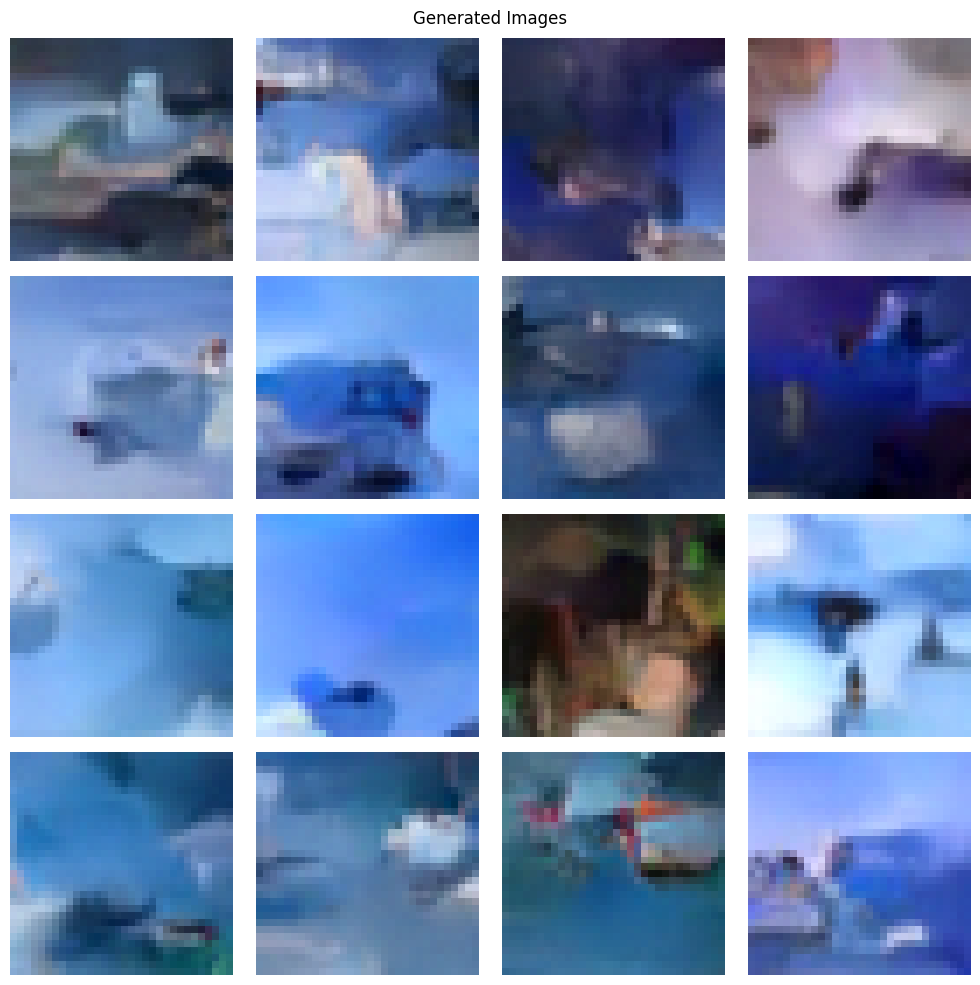

In [12]:
import torch
import matplotlib.pyplot as plt
import time # Import time for simple progress logging

# (This cell assumes all variables from previous cells are defined and in scope)
# Requires:
#   - model: Trained UNet model
#   - T_steps: Your total timesteps (e.g., 1000)
#   - DEVICE: Your "cuda" or "cpu" device
#   - All constants from vdm forward pass
#     (betas, alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance)
#     OR
#     (gamma, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance)

# --- Helper function for plotting ---
def unnormalize_img(img_tensor):
    """Converts a tensor from [-1, 1] to [0, 1] for plotting."""
    img_tensor = (img_tensor + 1) * 0.5
    img_tensor = torch.clamp(img_tensor, 0, 1) # Ensure values are in [0, 1]
    img_tensor = img_tensor.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    return img_tensor.cpu().numpy()

# --- Single-Step Denoising Function (p_sample) ---
# This is the core of the reverse process

@torch.no_grad() # We don't need gradients during sampling
def p_sample(model, x_t, t_tensor, t_index):
    """
    Performs a single denoising step from x_t to x_{t-1}
    """
    batch_size = x_t.shape[0]

    # --- 1. Get constants for this timestep 't' ---
    
    # Note: This logic works for EITHER the beta or gamma schedule,
    # as long as the constant tensors (betas, posterior_variance, etc.)
    # are correctly defined in the global scope from your forward pass file.
    
    # Use the gamma schedule's $\alpha_t$ and $\sigma_t$ if defined
    if 'gamma' in globals():
        # VDM / Gamma schedule logic
        gamma_t = gamma.gather(0, t_tensor).reshape(batch_size, 1, 1, 1)
        gamma_prev_t = F.pad(gamma[:-1], (1, 0), value=gamma[0]).gather(0, t_tensor).reshape(batch_size, 1, 1, 1)
        
        sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.gather(0, t_tensor).reshape(batch_size, 1, 1, 1)
        sqrt_sigmas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(0, t_tensor).reshape(batch_size, 1, 1, 1) # This is $\sigma_t$
        
        # Predict noise
        predicted_noise = model(x_t, t_tensor) # $\epsilon_\theta(x_t, t)$

        # Calculate $\hat{x}_0$ from $\epsilon_\theta$
        # $\hat{x}_0 = (x_t - \sigma_t \epsilon_\theta) / \alpha_t$
        x_start_pred = (x_t - sqrt_sigmas_cumprod_t * predicted_noise) / sqrt_alphas_cumprod_t
        
        # Calculate the mean of x_{t-1} using $\hat{x}_0$
        # This is the mean of $q(x_{t-1} | x_t, \hat{x}_0)$
        # (See VDM paper Appendix A.3, Eq 29, 32)
        alpha_s = torch.sqrt(torch.sigmoid(-gamma_prev_t))
        alpha_t = sqrt_alphas_cumprod_t
        sigma_t = sqrt_sigmas_cumprod_t
        c = -torch.expm1(gamma_prev_t - gamma_t) # $c = -expm1(\gamma_s - \gamma_t)$
        
        model_mean = (alpha_s / alpha_t) * (x_t - sigma_t * c * predicted_noise)

    else:
        # DDPM / Beta schedule logic
        beta_t = betas.gather(0, t_tensor).reshape(batch_size, 1, 1, 1)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(1. - beta_t))
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(0, t_tensor).reshape(batch_size, 1, 1, 1)
        
        predicted_noise = model(x_t, t_tensor)
        
        model_mean = sqrt_recip_alpha_t * (
            x_t - (beta_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        )

    if t_index == 0:
        return model_mean
    else:
        # --- 4. Add variance (stochasticity) ---
        noise = torch.randn_like(x_t)
        posterior_variance_t = posterior_variance.gather(0, t_tensor).reshape(batch_size, 1, 1, 1)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# --- 3. The Full Sampling Loop ---

@torch.no_grad()
def sample(model, batch_size, channels=3, img_size=IMG_SIZE):
    """
    Generates a batch of new images by sampling from T to 0.
    """
    print("--- Starting Sampling ---")
    start_time = time.time()

    # 1. Start with pure noise (x_T)
    x_t = torch.randn(
        (batch_size, channels, img_size, img_size),
        device=DEVICE
    )

    # 2. Loop backwards from T-1 down to 0
    # Removed tqdm wrapper
    for i in reversed(range(0, T_steps)):
        # Print progress every 100 steps
        if (i + 1) % 100 == 0:
            print(f"Sampling step {i+1}/{T_steps}")
            
        t_tensor = torch.full((batch_size,), i, device=DEVICE, dtype=torch.long)

        # 3. Perform one denoising step
        x_t = p_sample(model, x_t, t_tensor, i)

    end_time = time.time()
    print(f"--- Sampling Complete --- (Took {end_time - start_time:.2f}s)")

    # 4. Return the final denoised images (x_0)
    return x_t

# --- 4. Run Generation and Plot ---
if __name__ == "__main__":

    # Make sure model is in evaluation mode
    model.eval()

    # Generate 16 images
    NUM_IMAGES = 16
    generated_images = sample(model, batch_size=NUM_IMAGES)

    # --- Plot the results ---
    print("Generating plot of sampled images...")
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle("Generated Images")

    for i, img_tensor in enumerate(generated_images):
        row = i // 4
        col = i % 4

        img_np = unnormalize_img(img_tensor) # Convert to plot-able format

        axes[row, col].imshow(img_np)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()